# imports


In [1]:
#imports used 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#knn imports
from sklearn.neighbors import NearestNeighbors
from fancyimpute import KNN
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

# Data cleaning

In [2]:
# importing the initial data
data = pd.read_csv("data/data.csv")
data = data.fillna(0)

In [3]:
#setting the data values as int, incase the values are incorrectly improted as the wrong value
data.bedrooms = data.bedrooms.astype(int)
data.bathrooms = data.bathrooms.astype(int)
data.floors = data.floors.astype(int)

In [4]:
#removing unnessicary values
data = data.drop(["country","street","date"],axis=1)

In [5]:
#changing values into booleans to increase the accuracy of the algorithms
#step 1 - column to list
basement = data["sqft_basement"].values.tolist()
renovated = data["yr_renovated"].values.tolist()
Years = data["yr_built"].values.tolist()


In [6]:
#functions to change the value into binary yes(1) or no (2)
def Basement(basement):
    counter=0;
    for value in basement:
        if(value > 0):
            basement[counter] = 1
        counter= counter +1
    return basement

#renovated function to turn it into a boolean 
#1 = there is was renovated 
#0 = no renovated
def Renovated(renovated):
    counter=0
    for value in renovated:
        if(value > 0):
            renovated[counter] = 1
        counter= counter +1
    return renovated    
#smooth out buid years to the decade rather than year. this is to speed up the functions and also reduce complexity and giving more accurate results
#eg a year of 1996 is now 2000 and a year of 1994 is now 1990
def YearSmooth(Years):
    counter=0;
    for year in Years:
        if ((year % 10) > 4):
            x =10 - (year % 10)
            year = year +x 
        elif ((year % 10) < 5):
            year = year -(year % 10) 
        Years[counter] = year        
        counter= counter +1
    return Years

In [7]:
#calling these functions
data["basement"]=Basement(basement)
data["renovated"]=Renovated(renovated)
data["DecadeBuilt"] = YearSmooth(Years)

In [8]:
#removing unwanted values
data=data.drop("yr_renovated",axis=1)
data=data.drop("yr_built",axis=1)
data=data.drop("sqft_basement",axis=1)
#removing values that are not functional
data = data[data['price']>0]
data = data[data['bedrooms']>0]
data = data[data['bathrooms']>0]

In [9]:
#saving data as "CleanedData.csv"
data.to_csv("data/CleanedData.csv",index=False)

# grouping houses by similar features

In [10]:
#importing data that was cleaned to reduce errors
data = pd.read_csv("data/CleanedData.csv")

In [11]:
#grouping each house with compairable houses
def similarTo(PointOfIntrest,neightbourNumbers):
    dataX = data.drop(["city","sqft_above","statezip","price"],axis=1)
    neigh = NearestNeighbors(n_neighbors=neightbourNumbers)
    dataX = dataX.to_numpy()
    neigh.fit(dataX)
    neighbors_f_id = neigh.kneighbors_graph([dataX[PointOfIntrest]]).indices
    similar = data.iloc[neighbors_f_id]
    return similar
 

In [12]:
SimilarHouseGrouping=[]
for x in range(0,len(data)):
    SimilarHouseGrouping.append(similarTo(x,2))   

# Comapare Two houses


In [13]:
def houseCompare(SimilarHouseGrouping):
    SimilarHouseGrouping= SimilarHouseGrouping.drop(["city","statezip"],axis=1)
    return SimilarHouseGrouping.diff(axis=0)

In [14]:

houseCompare(SimilarHouseGrouping[1])

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,basement,renovated,DecadeBuilt
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3928,-1234000.0,0.0,0.0,-70.0,-129.0,0.0,0.0,-4.0,-2.0,210.0,-1.0,0.0,80.0


# compairing locatons

In [36]:
cities = data["city"].unique().tolist()
locaitonComp = pd.DataFrame({"Cities":cities,"pricing difference":0,"NumberOfEntries":0})

In [37]:
def locationsComp():
    for comparisons in range(0,len(SimilarHouseGrouping),1):
        x =SimilarHouseGrouping[comparisons][["price","city"]]
        city1 = x.iloc[0]["city"]
        city2 = x.iloc[1]["city"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = locaitonComp.loc[locaitonComp["Cities"] == city1]["pricing difference"].values
        num2 = locaitonComp.loc[locaitonComp["Cities"] == city2]["pricing difference"].values
        NoOfEntries1 = locaitonComp.loc[locaitonComp["Cities"] == city1]["NumberOfEntries"].values
        NoOfEntries2 = locaitonComp.loc[locaitonComp["Cities"] == city2]["NumberOfEntries"].values
        locaitonComp["pricing difference"].loc[locaitonComp["Cities"] == city1]=num1 + city1diff 
        locaitonComp["pricing difference"].loc[locaitonComp["Cities"] == city2]=num2 + city2diff
        locaitonComp["NumberOfEntries"].loc[locaitonComp["Cities"] == city1]=NoOfEntries1 + 1
        locaitonComp["NumberOfEntries"].loc[locaitonComp["Cities"] == city2]=NoOfEntries2 + 1

In [40]:
locationsComp()
dfCopy=locaitonComp.copy()
toNorm="pricing difference"
dfCopy[toNorm] = dfCopy[toNorm]/dfCopy["NumberOfEntries"]
locaitonComp[toNorm] = dfCopy[toNorm]/dfCopy[toNorm].abs().max()
locaitonComp.head()

C:\Users\Phili\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Cities,pricing difference,NumberOfEntries
0,Shoreline,0.212175,699
1,Seattle,0.284353,6120
2,Kent,0.252039,1092
3,Bellevue,0.403541,1503
4,Redmond,0.314991,1338


In [45]:
locaitonComp

,Cities,pricing difference,NumberOfEntries
0,Shoreline,0.212175,699
1,Seattle,0.284353,6120
2,Kent,0.252039,1092
3,Bellevue,0.403541,1503
4,Redmond,0.314991,1338
5,Maple Valley,0.166101,543
6,North Bend,0.197130,309
7,Lake Forest Park,0.228765,216
8,Sammamish,0.337617,1011
9,Auburn,0.143659,978


# Characteristic value

In [18]:
#value is scaled by the value of the location
#starting the bedrooms, bathrooms, floor, view, basements and if the property is renovated
bedrooms = data["bedrooms"].unique().tolist()
bedroomComp = pd.DataFrame({"bedrooms":bedrooms,"pricing difference":int(0)})

bathrooms = data["bathrooms"].unique().tolist()
bathroomsComp = pd.DataFrame({"bathrooms":bathrooms,"pricing difference":int(0)})

floors = data["floors"].unique().tolist()
floorsComp = pd.DataFrame({"floors":floors,"pricing difference":int(0)})

basement = data["basement"].unique().tolist()
basementComp = pd.DataFrame({"basement":basement,"pricing difference":int(0)})

In [19]:
def bedValueComp():
    for comparisons in range(0,len(difBedroomsValues),1):
        x =difBedroomsValues[comparisons][["price","bedrooms"]]
        city1 = x.iloc[0]["bedrooms"]
        city2 = x.iloc[1]["bedrooms"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = bedroomComp.loc[bedroomComp["bedrooms"] == city1]["pricing difference"].values
        num2 = bedroomComp.loc[bedroomComp["bedrooms"] == city2]["pricing difference"].values
        bedroomComp["pricing difference"].loc[bedroomComp["bedrooms"] == city1]=num1 + city1diff 
        bedroomComp["pricing difference"].loc[bedroomComp["bedrooms"] == city2]=num2 + city2diff  

def bathValueComp():
    for comparisons in range(0,len(difBathroomsValues),1):
        x =difBathroomsValues[comparisons][["price","bathrooms"]]
        city1 = x.iloc[0]["bathrooms"]
        city2 = x.iloc[1]["bathrooms"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = bathroomsComp.loc[bathroomsComp["bathrooms"] == city1]["pricing difference"].values
        num2 = bathroomsComp.loc[bathroomsComp["bathrooms"] == city2]["pricing difference"].values
        bathroomsComp["pricing difference"].loc[bathroomsComp["bathrooms"] == city1]=num1 + city1diff 
        bathroomsComp["pricing difference"].loc[bathroomsComp["bathrooms"] == city2]=num2 + city2diff  

def floorValueComp():
    for comparisons in range(0,len(difFloorsValues),1):
        x =difFloorsValues[comparisons][["price","floors"]]
        city1 = x.iloc[0]["floors"]
        city2 = x.iloc[1]["floors"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = floorsComp.loc[floorsComp["floors"] == city1]["pricing difference"].values
        num2 = floorsComp.loc[floorsComp["floors"] == city2]["pricing difference"].values
        floorsComp["pricing difference"].loc[floorsComp["floors"] == city1]=num1 + city1diff 
        floorsComp["pricing difference"].loc[floorsComp["floors"] == city2]=num2 + city2diff  

        
def basementValueComp():
    for comparisons in range(0,len(difBasementValues),1):
        x =difBasementValues[comparisons][["price","basement"]]
        city1 = x.iloc[0]["basement"]
        city2 = x.iloc[1]["basement"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = basementComp.loc[basementComp["basement"] == city1]["pricing difference"].values
        num2 = basementComp.loc[basementComp["basement"] == city2]["pricing difference"].values
        basementComp["pricing difference"].loc[basementComp["basement"] == city1]=num1 + city1diff 
        basementComp["pricing difference"].loc[basementComp["basement"] == city2]=num2 + city2diff  

def basementValueComp():
    for comparisons in range(0,len(difBasementValues),1):
        x =difBasementValues[comparisons][["price","basement"]]
        city1 = x.iloc[0]["basement"]
        city2 = x.iloc[1]["basement"]
        city1diff = x.iloc[0]["price"]
        city2diff = x.iloc[1]["price"]
        num1 = basementComp.loc[basementComp["basement"] == city1]["pricing difference"].values
        num2 = basementComp.loc[basementComp["basement"] == city2]["pricing difference"].values
        basementComp["pricing difference"].loc[basementComp["basement"] == city1]=num1 + city1diff 
        basementComp["pricing difference"].loc[basementComp["basement"] == city2]=num2 + city2diff  

In [20]:
difBedroomsValues = []
for comps in range(0,len(SimilarHouseGrouping),1):
    x =SimilarHouseGrouping[comps]
    if (x.iloc[0]["bedrooms"] != x.iloc[1]["bedrooms"] and x.iloc[0]["bathrooms"] == x.iloc[1]["bathrooms"]
       and x.iloc[0]["floors"] == x.iloc[1]["floors"] and x.iloc[0]["basement"] == x.iloc[1]["basement"] ):
        difBedroomsValues.append(SimilarHouseGrouping[comps])

bedValueComp()
dfCopy=bedroomComp.copy()
toNorm="pricing difference"
bedroomComp[toNorm] = dfCopy[toNorm]/dfCopy[toNorm].abs().max()

C:\Users\Phili\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
difBathroomsValues = []
for comps in range(0,len(SimilarHouseGrouping),1):
    x =SimilarHouseGrouping[comps]
    if (x.iloc[0]["bathrooms"] != x.iloc[1]["bathrooms"] and x.iloc[0]["bedrooms"] == x.iloc[1]["bedrooms"]
       and x.iloc[0]["floors"] == x.iloc[1]["floors"] and x.iloc[0]["basement"] == x.iloc[1]["basement"] ):
        difBathroomsValues.append(SimilarHouseGrouping[comps])

bathValueComp()
dfCopy=bathroomsComp.copy()
toNorm="pricing difference"
bathroomsComp[toNorm] = dfCopy[toNorm]/dfCopy[toNorm].abs().max()

In [22]:
difFloorsValues = []
for comps in range(0,len(SimilarHouseGrouping),1):
    x =SimilarHouseGrouping[comps]
    if (x.iloc[0]["bathrooms"] == x.iloc[1]["bathrooms"] and x.iloc[0]["bedrooms"] == x.iloc[1]["bedrooms"]
       and x.iloc[0]["floors"] != x.iloc[1]["floors"] and x.iloc[0]["basement"] == x.iloc[1]["basement"] ):
        difFloorsValues.append(SimilarHouseGrouping[comps])

floorValueComp()
dfCopy=floorsComp.copy()
toNorm="pricing difference"
floorsComp[toNorm] = dfCopy[toNorm]/dfCopy[toNorm].abs().max()

In [23]:
difBasementValues = []
for comps in range(0,len(SimilarHouseGrouping),1):
    x =SimilarHouseGrouping[comps]
    if (x.iloc[0]["bathrooms"] == x.iloc[1]["bathrooms"] and x.iloc[0]["bedrooms"] == x.iloc[1]["bedrooms"]
       and x.iloc[0]["floors"] == x.iloc[1]["floors"] and x.iloc[0]["basement"] != x.iloc[1]["basement"] ):
        difBasementValues.append(SimilarHouseGrouping[comps])

basementValueComp()
dfCopy=basementComp.copy()
toNorm="pricing difference"
basementComp[toNorm] = dfCopy[toNorm]/dfCopy[toNorm].abs().max()

In [24]:
basementComp

,basement,pricing difference
0,0,0.896883
1,1,1.000000


Text(0.5, 1.0, 'normalized value added by the number of bedrooms a house has. 1 being the highest value')

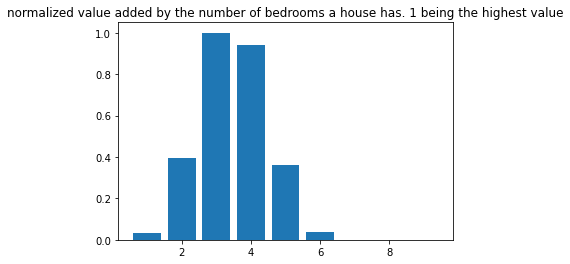

In [25]:
plt.bar(bedroomComp["bedrooms"],bedroomComp["pricing difference"])
plt.title("normalized value added by the number of bedrooms a house has. 1 being the highest value")

Text(0.5, 1.0, '')

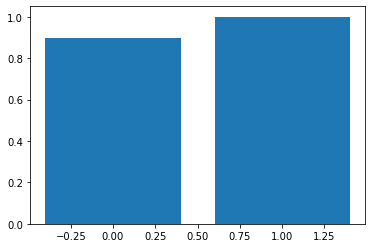

In [26]:
plt.bar(basementComp["basement"],basementComp["pricing difference"])
plt.title("")

# property input

In [27]:
columnsTOBeInput=data.columns.values

In [ ]:
inputVals =[]
temp = 0
for x in range(0,len(columnsTOBeInput),1):
    print("------------------")
    print("Enter the value you want for : "+columnsTOBeInput[x])
    print("minimum value : " +str(data[columnsTOBeInput[x]].min())+ " Maximum value : " +str(data[columnsTOBeInput[x]].max()) + " of houses that are avalilible")
    numberInput = input ("Enter Target " + columnsTOBeInput[x] + ":")
    
    if(columnsTOBeInput[x] == "city" ):
        for city in data["city"] :
            if (numberInput == city):
                temp = 1
        if(temp ==0):
            numberInput="Kent"
                
    elif (columnsTOBeInput[x] =="statezip"):
        for state in data["statezip"]:
            if (numberInput == state):
                temp = 1        
        if(temp ==0):
            numberInput="WA 98042"
    else:
        numberInput = int(numberInput)
        if(int(numberInput) < data[columnsTOBeInput[x]].min() ):
            print("There are no properties with a " +columnsTOBeInput[x]+ "below this, minimum value will be set")
            numberInput = data[columnsTOBeInput[x]].min()

        if(int(numberInput) >data[columnsTOBeInput[x]].max() ):
            print("There are no properties with a " +columnsTOBeInput[x]+ "above this, maximum value will be set")
            numberInput = data[columnsTOBeInput[x]].max()
            
    inputVals.append(numberInput)
    print("Inputs Taken")
    


In [47]:
inputVals[0]

7800.0

In [48]:
data.loc[len(data)]= inputVals
similarTo(len(data)-1,2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,city,statezip,basement,renovated,DecadeBuilt
4534,7800.0,1,1,520.0,638.0,1,1,1,1,520.0,Kent,WA 98042,1,1,1900.0
4532,7800.0,1,1,520.0,638.0,1,1,1,1,520.0,kent,WA 98042,1,1,1900.0


# properties around the searched property changing values to ones close.
this will involve changing variables up and down

In [49]:
inputValsPlusOne=[]

for x in inputVals:
    if type(x) is str:
        inputValsPlusOne.append(x)
    elif x < 10:
        x = x + 1
        inputValsPlusOne.append(x)
    elif x > 10:
        x = x * 1.1
        inputValsPlusOne.append(x)
    
inputValsMinusOne=[]
if(inputVals[0]==7800.0):
    print("minimum value is reached")
else:
    for x in inputVals:
        if type(x) is str:
            inputValsMinusOne.append(x)

        elif x < 10:
            if x >1:
                x = x + 1
                inputValsMinusOne.append(x)
        elif x > 10:
            x = x * .9
            inputValsMinusOne.append(x)


minimum value is reached


In [50]:
data.loc[len(data)]= inputValsPlusOne
similarTo(len(data)-1,2)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,city,statezip,basement,renovated,DecadeBuilt
4533,8580.0,2,2,572.0,701.8,2,2,2,2,572.0,kent,WA 98042,2,2,2090.0
4535,8580.0,2,2,572.0,701.8,2,2,2,2,572.0,Kent,WA 98042,2,2,2090.0


In [51]:
data.loc[len(data)]= inputValsMinusOne
similarTo(len(data)-1,2)

ValueError: cannot set a row with mismatched columns

In [52]:
data.iloc[len(data)-1]


price              8580
bedrooms              2
bathrooms             2
sqft_living         572
sqft_lot          701.8
floors                2
waterfront            2
view                  2
condition             2
sqft_above          572
city               Kent
statezip       WA 98042
basement              2
renovated             2
DecadeBuilt        2090
Name: 4535, dtype: object

In [ ]:
len(data)